# Generating Character Names with RNNs

I code this notebook by following this pytorch tutorial on RNNs : https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn

In [3]:

letters = string.ascii_letters + ".,;'-"
number_of_letters = len(letters)


def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [4]:
# Build the category_lines dictionary, a list of lines per category
category_lines = {}
categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(categories)

if n_categories == 0:
    raise RuntimeError('Data not found')

print('Categories ({}): {}'.format(n_categories, categories))

Categories (18): ['Japanese', 'German', 'English', 'Scottish', 'Korean', 'Portuguese', 'Russian', 'Irish', 'Arabic', 'Polish', 'Chinese', 'Vietnamese', 'Czech', 'Spanish', 'French', 'Italian', 'Dutch', 'Greek']


## Model 

The network takes as input : category (one-hot vector), previous output and previous hidden value.

In [5]:
class RNN(nn.Module):
    def __init__(self, in_size, h_size, out_size):
        super(RNN, self).__init__()
        self.in_size = in_size
        self.h_size = h_size
        self.out_size = out_size

        #Layers : 

        self.i2h = nn.Linear(n_categories + self.in_size + self.h_size, self.h_size)
        self.i2o = nn.Linear(n_categories + self.in_size + self.h_size, self.out_size)
        self.o2o = nn.Linear(self.out_size + self.h_size, self.out_size)

        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim =1)

    
    def forward(self, category, input, in_hidden):
        in_concat = torch.cat((category, input, in_hidden),1)
        output = self.i2o(in_concat)
        hidden = self.i2h(in_concat)
        out_combined = torch.cat((output,hidden),1)
        out = self.o2o(out_combined)
        out = self.dropout(out)
        out = self.softmax(out)
        return out, hidden

    
    def init_hidden(self):
        return torch.zeros(1,self.h_size)





## Training 

In [6]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(categories)
    line = randomChoice(category_lines[category])
    return category, line


def create_categories_tensor(category):
    indx = categories.index(category)
    t = torch.zeros(1,n_categories)
    t[0][indx] = 1 # one hot vector
    return t 


def inputTensor(line):
    tensor = torch.zeros(len(line), 1, number_of_letters)
    for i in range(len(line)):
        letter = line[i]
        tensor[i][0][letters.find(letter)] = 1 # one hot vector
    return tensor

def targetTensor(line):
    letter_indx = [letters.find(line[i]) for i in range(1,len(line))]
    letter_indx.append(number_of_letters - 1) # EOS 
    return torch.LongTensor(letter_indx)


def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = create_categories_tensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [7]:
# training  :


criterion = nn.NLLLoss()
learning_rate = 0.001

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze(-1)
    hidden = rnn.init_hidden()

    rnn.zero_grad()
    loss = 0 
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        #print("Target : ", target_line_tensor[i].unsqueeze(0).shape)
        #print("Output : ", output.shape)
        l = criterion(output, target_line_tensor[i].unsqueeze(0))
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)
    
    return output, loss.item() / input_line_tensor.size(0)

In [8]:
rnn = RNN(number_of_letters, 128, number_of_letters)
n_iters = 100000
print_every = 5000
plot_every = 500
losses = []
total_loss = 0


for iter in range(1, n_iters+1):
    output, loss = train(*randomTrainingExample()) # * -> unpack
    total_loss += loss


    if iter % print_every == 0:
        print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        losses.append(total_loss / plot_every)
        total_loss = 0




/home/erik/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
(5000 5%) 2.4360
(10000 10%) 2.9560
(15000 15%) 2.4158
(20000 20%) 2.0988
(25000 25%) 1.7378
(30000 30%) 2.8086
(35000 35%) 2.0868
(40000 40%) 1.7436
(45000 45%) 2.2024
(50000 50%) 3.7529
(55000 55%) 2.4734
(60000 60%) 1.7925
(65000 65%) 3.0674
(70000 70%) 2.7192
(75000 75%) 2.1963
(80000 80%) 2.6140
(85000 85%) 2.3251
(90000 90%) 2.0651
(95000 95%) 2.0816
(100000 100%) 1.7940


### Ploting loss :


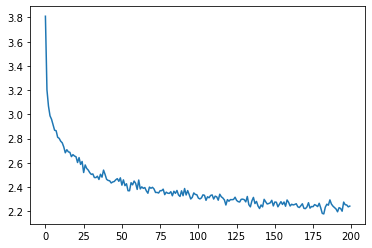

In [9]:
import matplotlib.pyplot as plt


plt.plot(losses)

## Sampling the network


In [33]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = create_categories_tensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.init_hidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == number_of_letters - 1:
                break
            else:
                letter = letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')
samples('French','J')


Romankovov
Uakhonov
Sakovakoveky
Janerre
